Epoch 1/100, Train Loss: 0.4843, Train Accuracy: 0.8540, Valid Loss: 0.1474, Valid Accuracy: 0.9565
Epoch 2/100, Train Loss: 0.1474, Train Accuracy: 0.9545, Valid Loss: 0.1364, Valid Accuracy: 0.9547
Epoch 3/100, Train Loss: 0.1469, Train Accuracy: 0.9519, Valid Loss: 0.1318, Valid Accuracy: 0.9553
Epoch 4/100, Train Loss: 0.1321, Train Accuracy: 0.9556, Valid Loss: 0.1218, Valid Accuracy: 0.9598
Epoch 5/100, Train Loss: 0.1262, Train Accuracy: 0.9575, Valid Loss: 0.1203, Valid Accuracy: 0.9584
Epoch 6/100, Train Loss: 0.1245, Train Accuracy: 0.9597, Valid Loss: 0.1126, Valid Accuracy: 0.9626
Epoch 7/100, Train Loss: 0.1228, Train Accuracy: 0.9601, Valid Loss: 0.1124, Valid Accuracy: 0.9632
Epoch 8/100, Train Loss: 0.1212, Train Accuracy: 0.9613, Valid Loss: 0.1174, Valid Accuracy: 0.9604
Epoch 9/100, Train Loss: 0.1154, Train Accuracy: 0.9626, Valid Loss: 0.1142, Valid Accuracy: 0.9641
Epoch 10/100, Train Loss: 0.1174, Train Accuracy: 0.9619, Valid Loss: 0.1128, Valid Accuracy: 0.9642

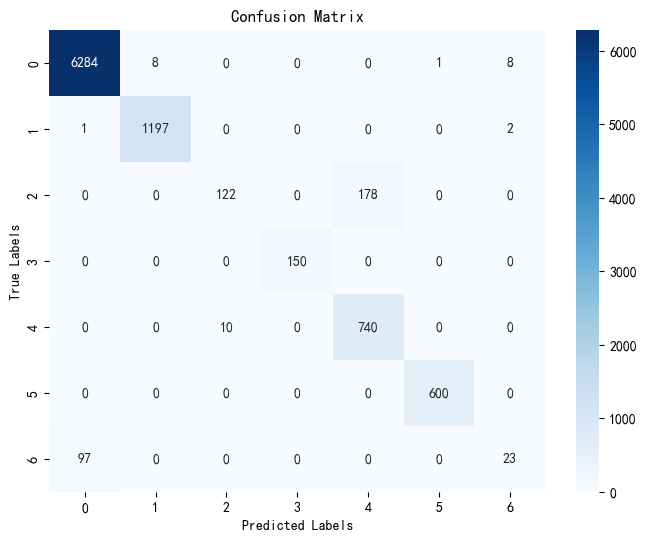

Plot the accuracy and loss curve


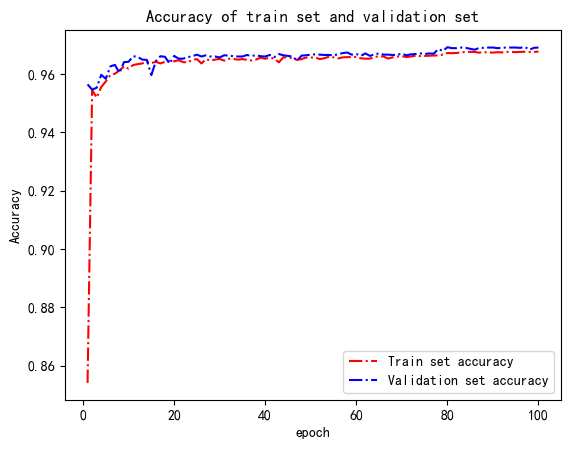

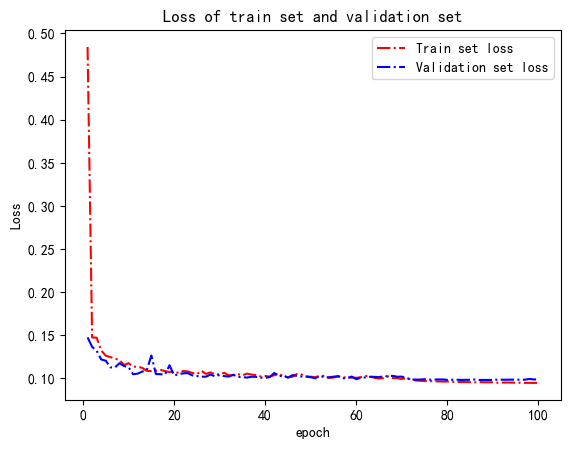

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import random
import warnings
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns

# Suppress warnings
warnings.filterwarnings("ignore")

# Set font for Chinese characters
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# Data preprocessing
def preprocess_data(file_path, split_rate):
    """Load and preprocess the dataset."""
    try:
        df = pd.read_csv(file_path)
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(0, inplace=True)

        # Split features and labels
        X = df.iloc[:, 3:-1].values  # Features
        y = df.iloc[:, -1].values    # Labels

        # Split dataset into train, validation, and test sets
        x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=1 - split_rate, stratify=y, random_state=42)
        x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

        # Normalize features to [0, 255]
        scaler = MinMaxScaler(feature_range=(0, 255))
        x_train = scaler.fit_transform(x_train)
        x_valid = scaler.transform(x_valid)
        x_test = scaler.transform(x_test)

        return x_train, y_train, x_valid, y_valid, x_test, y_test
    except Exception as e:
        print(f"Error during data preprocessing: {e}")
        raise

# Prepare data for model input
def prepare_data(x_train, y_train, x_valid, y_valid, x_test, y_test, sequence_length):
    """Prepare data for model input."""
    # Convert labels to integers
    y_train = np.array([int(i) for i in y_train])
    y_valid = np.array([int(i) for i in y_valid])
    y_test = np.array([int(i) for i in y_test])

    # Shuffle data
    for data in [(x_train, y_train), (x_valid, y_valid), (x_test, y_test)]:
        indices = np.arange(len(data[0]))
        np.random.seed(1)
        np.random.shuffle(indices)
        data[0][:], data[1][:] = data[0][indices], data[1][indices]

    # Reshape data for CNN input: (batch_size, channels, sequence_length)
    if len(x_train.shape) == 2:
        x_train = np.expand_dims(x_train, axis=1)  # Add channel dimension
        x_valid = np.expand_dims(x_valid, axis=1)
        x_test = np.expand_dims(x_test, axis=1)

    # Convert to PyTorch tensors
    x_train = torch.tensor(x_train, dtype=torch.float32)
    x_valid = torch.tensor(x_valid, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)

    y_train = torch.tensor(y_train, dtype=torch.long)
    y_valid = torch.tensor(y_valid, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    return x_train, y_train, x_valid, y_valid, x_test, y_test

# CNN + LSTM Model
class CNNLSTMModel(nn.Module):
    def __init__(self, input_channels, sequence_length, hidden_size, num_layers, num_classes):
        super(CNNLSTMModel, self).__init__()
        # CNN layers
        self.cnn = nn.Sequential(
            nn.Conv1d(input_channels, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        # LSTM layer
        self.lstm = nn.LSTM(16, hidden_size, num_layers, batch_first=True, dropout=0.1)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # CNN feature extraction
        x = self.cnn(x)  # (batch_size, channels, sequence_length)
        x = x.permute(0, 2, 1)  # (batch_size, sequence_length, features)
        # LSTM sequence processing
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))  # (batch_size, sequence_length, hidden_size)
        # Take the last time step's output
        out = out[:, -1, :]  # (batch_size, hidden_size)
        # Classification
        out = self.fc(out)  # (batch_size, num_classes)
        return out

# Model training
def train_model(x_train, y_train, x_valid, y_valid, x_test, y_test, batch_size, epochs):
    """Train the CNN + LSTM model."""
    # Create DataLoader
    train_dataset = TensorDataset(x_train, y_train)
    valid_dataset = TensorDataset(x_valid, y_valid)
    test_dataset = TensorDataset(x_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss function, and optimizer
    input_channels = x_train.shape[1]
    sequence_length = x_train.shape[2]
    hidden_size = 64
    num_layers = 2
    num_classes = len(torch.unique(y_train))

    model = CNNLSTMModel(input_channels, sequence_length, hidden_size, num_layers, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

    # Training loop
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    patience, best_val_loss, counter = 20, float('inf'), 0

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels)

        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct.double() / len(train_loader.dataset)

        # Validation
        model.eval()
        valid_loss, valid_correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                valid_correct += torch.sum(preds == labels)

        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = valid_correct.double() / len(valid_loader.dataset)

        # Record metrics
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        # Early stopping
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

        # Update learning rate
        scheduler.step(valid_loss)

        print(f'Epoch {epoch + 1}/{epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

    # Test evaluation
    model.eval()
    test_correct, y_pred, y_true = 0, [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_correct += torch.sum(preds == labels)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    test_accuracy = test_correct.double() / len(test_loader.dataset)
    print("Test Accuracy: {:.2%}".format(test_accuracy))
    print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return {
        'loss': train_losses,
        'val_loss': valid_losses,
        'accuracy': train_accuracies,
        'val_accuracy': valid_accuracies
    }, model

# Plot accuracy and loss curves
def plot_metrics(history):
    print("Plot the accuracy and loss curve")
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'r', linestyle='-.')
    plt.plot(epochs, val_acc, 'b', linestyle='dashdot')
    plt.title('Accuracy of train set and validation set')
    plt.xlabel("epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Train set accuracy", "Validation set accuracy"])

    plt.figure()


    plt.plot(epochs, loss, 'r', linestyle='-.')
    plt.plot(epochs, val_loss, 'b', linestyle='dashdot')
    plt.title('Loss of train set and validation set')
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.legend(["Train set loss", "Validation set loss"])

    plt.show()

# Main function
if __name__ == '__main__':
    file_path = '../data/cic.csv'
    split_rate = 0.7
    batch_size = 128
    epochs = 100
    sequence_length = 76

    # Preprocess data
    x_train, y_train, x_valid, y_valid, x_test, y_test = preprocess_data(file_path, split_rate)
    x_train, y_train, x_valid, y_valid, x_test, y_test = prepare_data(x_train, y_train, x_valid, y_valid, x_test, y_test, sequence_length)

    # Train model
    history, model = train_model(x_train, y_train, x_valid, y_valid, x_test, y_test, batch_size, epochs)

    # Plot metrics
    plot_metrics(history)